In [1]:
import os, warnings, math, json, joblib
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
target_pairs = pd.read_csv("../data/target_pairs.csv")
train_labels = pd.read_csv("../data/train_labels.csv")
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
test_labels_lag_1 = pd.read_csv("../data/lagged_test_labels/test_labels_lag_1.csv")
test_labels_lag_2 = pd.read_csv("../data/lagged_test_labels/test_labels_lag_2.csv")
test_labels_lag_3 = pd.read_csv("../data/lagged_test_labels/test_labels_lag_3.csv")
test_labels_lag_4 = pd.read_csv("../data/lagged_test_labels/test_labels_lag_4.csv")

In [3]:
if 'date_id' in train.columns:
    train = train.set_index('date_id')

In [4]:
def create_exchange_dataframes(train):
    lme_cols = []
    jpx_cols = []
    fx_cols = []
    us_cols = []
    for col in train.columns:
        if col.endswith('_Close') or col.endswith('_close'):
            if col.startswith('LME'):
                lme_cols.append(col)
            elif col.startswith('JPX'):
                jpx_cols.append(col)
            elif col.startswith('US'):
                us_cols.append(col)
        if col.startswith('FX'):
            fx_cols.append(col)

    exchanges_data = {
        'US': pd.DataFrame(),
        'LME': pd.DataFrame(),
        'FX': pd.DataFrame(),
        'JPX': pd.DataFrame()
    }
    
    
    if lme_cols:
        exchanges_data['LME'] = train[lme_cols]
    if jpx_cols:
        exchanges_data['JPX'] = train[jpx_cols]
    if fx_cols:
        exchanges_data['FX'] = train[fx_cols]
    if us_cols:
        exchanges_data['US'] = train[us_cols]

    return exchanges_data

EXCHANGES = create_exchange_dataframes(train)

In [5]:
# EXCHANGES['LME']

In [6]:
# EXCHANGES['JPX']

In [7]:
# EXCHANGES['FX']

In [8]:
# EXCHANGES['US']

In [9]:
# US_Stock_GOLD_adj_close has too many null values, hence dropped

In [10]:
if 'US_Stock_GOLD_adj_close' in EXCHANGES['US'].columns:
    EXCHANGES['US'] = EXCHANGES['US'].drop(columns=['US_Stock_GOLD_adj_close'])
EXCHANGES['US'].shape    

(1961, 94)

In [11]:
def plot_stock_data(df, column_name, title):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=df.index, y=column_name)
    plt.title(title)
    plt.xlabel('Date ID')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# print("\n--- Plotting All Stocks on One Figure Per Exchange ---")
# for exchange_name, df_exchange in EXCHANGES.items():
#     if not df_exchange.empty:
#         plt.figure(figsize=(15, 8))
#         for col in df_exchange.columns:
#             sns.lineplot(data=df_exchange, x=df_exchange.index, y=col, label=col)
#         plt.title(f'All Stocks in {exchange_name} Exchange')
#         plt.xlabel('Date ID')
#         plt.ylabel('Value')
#         plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()
#     else:
#         print(f"No data for {exchange_name} Exchange to plot all stocks on one figure.")

# print("\n--- Plotting Individual Stock Figures Per Exchange ---")
# for exchange_name, df_exchange in EXCHANGES.items():
#     if not df_exchange.empty:
#         print(f"\nPlots for {exchange_name} Exchange:")
#         for col in df_exchange.columns:
#             plot_stock_data(df_exchange, col, f'{col} in {exchange_name} Exchange')
#     else:
#         print(f"No data for {exchange_name} Exchange to plot individual stocks.")

In [16]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

def comprehensive_statistical_tests(series, commodity_name, exchange_name):
    """
    Perform all statistical tests on a single commodity time series.

    Parameters:
    -----------
    series : pd.Series
        Time series data
    commodity_name : str
        Name of the commodity
    exchange_name : str
        Exchange category

    Returns:
    --------
    dict : Dictionary containing all test results
    """

    results = {
        'commodity': commodity_name,
        'exchange': exchange_name,
        'n_observations': len(series),
        'missing_count': series.isna().sum(),
        'missing_pct': (series.isna().sum() / len(series)) * 100
    }

    # Clean series for testing
    clean_series = series.dropna()

    if len(clean_series) < 10:
        # Insufficient data
        for key in ['adf_statistic', 'adf_pvalue', 'adf_critical_1pct', 'adf_critical_5pct',
                    'adf_critical_10pct', 'adf_stationary', 'kpss_statistic', 'kpss_pvalue',
                    'kpss_critical_10pct', 'kpss_critical_5pct', 'kpss_critical_1pct',
                    'kpss_stationary', 'ljungbox_statistic', 'ljungbox_pvalue', 'autocorrelated',
                    'normality_statistic', 'normality_pvalue', 'is_normal', 'skewness', 'kurtosis',
                    'log_normality_pvalue', 'is_log_normal', 'linear_corr', 'linear_pvalue',
                    'has_linear_trend', 'mean', 'std', 'min', 'max', 'median']:
            results[key] = np.nan
        return results

    # Basic descriptive statistics
    results['mean'] = clean_series.mean()
    results['std'] = clean_series.std()
    results['min'] = clean_series.min()
    results['max'] = clean_series.max()
    results['median'] = clean_series.median()

    # TEST 1: Augmented Dickey-Fuller (ADF) Test
    try:
        adf_result = adfuller(clean_series, autolag='AIC')
        results['adf_statistic'] = adf_result[0]
        results['adf_pvalue'] = adf_result[1]
        results['adf_critical_1pct'] = adf_result[4]['1%']
        results['adf_critical_5pct'] = adf_result[4]['5%']
        results['adf_critical_10pct'] = adf_result[4]['10%']
        results['adf_stationary'] = adf_result[1] < 0.05  # Reject null hypothesis of unit root
    except Exception as e:
        print(f"ADF test failed for {commodity_name}: {e}")
        for key in ['adf_statistic', 'adf_pvalue', 'adf_critical_1pct', 'adf_critical_5pct',
                    'adf_critical_10pct', 'adf_stationary']:
            results[key] = np.nan

    # TEST 2: KPSS Test
    try:
        kpss_result = kpss(clean_series, regression='c', nlags='auto')
        results['kpss_statistic'] = kpss_result[0]
        results['kpss_pvalue'] = kpss_result[1]
        results['kpss_critical_10pct'] = kpss_result[3]['10%']
        results['kpss_critical_5pct'] = kpss_result[3]['5%']
        results['kpss_critical_1pct'] = kpss_result[3]['1%']
        results['kpss_stationary'] = kpss_result[1] > 0.05  # Fail to reject null of stationarity
    except Exception as e:
        print(f"KPSS test failed for {commodity_name}: {e}")
        for key in ['kpss_statistic', 'kpss_pvalue', 'kpss_critical_10pct',
                    'kpss_critical_5pct', 'kpss_critical_1pct', 'kpss_stationary']:
            results[key] = np.nan

    # TEST 3: Ljung-Box Test for Autocorrelation
    try:
        lb_result = acorr_ljungbox(clean_series, lags=[min(10, len(clean_series)//4)], return_df=True)
        results['ljungbox_statistic'] = lb_result['lb_stat'].values[0]
        results['ljungbox_pvalue'] = lb_result['lb_pvalue'].values[0]
        results['autocorrelated'] = lb_result['lb_pvalue'].values[0] < 0.05
    except Exception as e:
        print(f"Ljung-Box test failed for {commodity_name}: {e}")
        for key in ['ljungbox_statistic', 'ljungbox_pvalue', 'autocorrelated']:
            results[key] = np.nan

    # TEST 4: Normality Test (D'Agostino-Pearson)
    try:
        normality_result = stats.normaltest(clean_series)
        results['normality_statistic'] = normality_result.statistic
        results['normality_pvalue'] = normality_result.pvalue
        results['is_normal'] = normality_result.pvalue > 0.05
        results['skewness'] = stats.skew(clean_series)
        results['kurtosis'] = stats.kurtosis(clean_series)
    except Exception as e:
        print(f"Normality test failed for {commodity_name}: {e}")
        for key in ['normality_statistic', 'normality_pvalue', 'is_normal', 'skewness', 'kurtosis']:
            results[key] = np.nan

    # TEST 5: Log-Normality Test
    try:
        if (clean_series > 0).all():
            log_series = np.log(clean_series)
            log_norm_result = stats.normaltest(log_series)
            results['log_normality_pvalue'] = log_norm_result.pvalue
            results['is_log_normal'] = log_norm_result.pvalue > 0.05
        else:
            results['log_normality_pvalue'] = np.nan
            results['is_log_normal'] = False
    except Exception as e:
        print(f"Log-normality test failed for {commodity_name}: {e}")
        results['log_normality_pvalue'] = np.nan
        results['is_log_normal'] = False

    # TEST 6: Linear Trend Test (Pearson correlation with time)
    try:
        time_index = np.arange(len(clean_series))
        corr_result = stats.pearsonr(time_index, clean_series)
        results['linear_corr'] = corr_result[0]
        results['linear_pvalue'] = corr_result[1]
        results['has_linear_trend'] = corr_result[1] < 0.05
    except Exception as e:
        print(f"Linear trend test failed for {commodity_name}: {e}")
        for key in ['linear_corr', 'linear_pvalue', 'has_linear_trend']:
            results[key] = np.nan

    return results

In [17]:
print("="*80)
print("RUNNING STATISTICAL TESTS ON RAW DATA")
print("="*80)

raw_test_results = []

for exchange_name, commodities_df in EXCHANGES.items():
    if commodities_df.empty:
        continue

    print(f"\n{exchange_name} Exchange:")
    for commodity in commodities_df.columns:
        print(f"  Testing: {commodity}...", end=" ")
        series = commodities_df[commodity]
        results = comprehensive_statistical_tests(series, commodity, exchange_name)
        raw_test_results.append(results)

        # Print key findings
        # adf_stat = "Stationary" if results.get('adf_stationary', False) else "Non-stationary"
        # kpss_stat = "Stationary" if results.get('kpss_stationary', False) else "Non-stationary"
        # print(f"ADF: {adf_stat}, KPSS: {kpss_stat}")

raw_results_df = pd.DataFrame(raw_test_results)
print(f"\n\u2713 Completed testing {len(raw_test_results)} commodities")
print(f"\nRaw Data Summary:")
print(f"  Stationary (ADF): {raw_results_df['adf_stationary'].sum()} / {len(raw_results_df)} ({raw_results_df['adf_stationary'].mean()*100:.1f}%)")
print(f"  Stationary (KPSS): {raw_results_df['kpss_stationary'].sum()} / {len(raw_results_df)} ({raw_results_df['kpss_stationary'].mean()*100:.1f}%)")
print(f"  Autocorrelated: {raw_results_df['autocorrelated'].sum()} / {len(raw_results_df)} ({raw_results_df['autocorrelated'].mean()*100:.1f}%)")
print(f"  Normal: {raw_results_df['is_normal'].sum()} / {len(raw_results_df)} ({raw_results_df['is_normal'].mean()*100:.1f}%)")
print(f"  Log-normal: {raw_results_df['is_log_normal'].sum()} / {len(raw_results_df)} ({raw_results_df['is_log_normal'].mean()*100:.1f}%)")

RUNNING STATISTICAL TESTS ON RAW DATA

US Exchange:
  Testing: US_Stock_ACWI_adj_close...   Testing: US_Stock_AEM_adj_close...   Testing: US_Stock_AG_adj_close...   Testing: US_Stock_AGG_adj_close...   Testing: US_Stock_ALB_adj_close...   Testing: US_Stock_AMP_adj_close...   Testing: US_Stock_BCS_adj_close...   Testing: US_Stock_BKR_adj_close...   Testing: US_Stock_BND_adj_close...   Testing: US_Stock_BNDX_adj_close...   Testing: US_Stock_BP_adj_close...   Testing: US_Stock_BSV_adj_close...   Testing: US_Stock_CAT_adj_close...   Testing: US_Stock_CCJ_adj_close...   Testing: US_Stock_CLF_adj_close...   Testing: US_Stock_COP_adj_close...   Testing: US_Stock_CVE_adj_close...   Testing: US_Stock_CVX_adj_close...   Testing: US_Stock_DE_adj_close...   Testing: US_Stock_DVN_adj_close...   Testing: US_Stock_EEM_adj_close...   Testing: US_Stock_EFA_adj_close...   Testing: US_Stock_EMB_adj_close...   Testing: US_Stock_ENB_adj_close...   Testing: US_Stock_EOG_adj_close...   Testing: US_Stock_EWJ_

In [18]:
print("\nStatistical Test P-Values:")
display(raw_results_df[['commodity', 'exchange', 'adf_pvalue', 'kpss_pvalue', 'ljungbox_pvalue', 'normality_pvalue', 'log_normality_pvalue']])


Statistical Test P-Values:


,commodity,exchange,adf_pvalue,kpss_pvalue,ljungbox_pvalue,normality_pvalue,log_normality_pvalue
0,US_Stock_ACWI_adj_close,US,0.968911,0.01,0.0,1.750314e-47,9.228607e-136
1,US_Stock_AEM_adj_close,US,0.992621,0.01,0.0,3.470845e-124,7.153160e-32
2,US_Stock_AG_adj_close,US,0.171695,0.01,0.0,6.682489e-66,5.836904e-35
3,US_Stock_AGG_adj_close,US,0.547868,0.01,0.0,0.000000e+00,0.000000e+00
4,US_Stock_ALB_adj_close,US,0.544598,0.01,0.0,1.182154e-63,0.000000e+00
...,...,...,...,...,...,...,...
137,JPX_Gold_Rolling-Spot_Futures_Close,JPX,1.000000,0.01,0.0,2.505599e-57,2.681660e-35
138,JPX_Gold_Standard_Futures_Close,JPX,1.000000,0.01,0.0,3.280978e-54,4.964727e-38
139,JPX_Platinum_Mini_Futures_Close,JPX,0.901822,0.01,0.0,9.471186e-11,1.043537e-31
140,JPX_Platinum_Standard_Futures_Close,JPX,0.903139,0.01,0.0,7.824061e-11,1.777326e-32


In [37]:
def apply_log_transformation(df, commodity_cols):
    """Apply log transformation to all commodity columns"""
    df_transformed = df.copy()
    log_data = {}

    for col in commodity_cols:
        if col in df_transformed.columns:
            series = df_transformed[col].copy()

            # Handle negative or zero values by shifting
            min_val = series.min()
            if min_val <= 0:
                shift_amount = abs(min_val) + 1
                series = series + shift_amount
                # print(f"  {col}: Shifted by {shift_amount:.2f} before log") # Removed for cleaner output

            # Apply log transformation
            log_data[f'{col}_log'] = np.log(series)

    if log_data:
        df_transformed = pd.concat([df_transformed, pd.DataFrame(log_data, index=df.index)], axis=1)
    return df_transformed

def apply_differencing(df, log_cols):
    """Apply first-order differencing to log-transformed columns"""
    df_diff = df.copy()
    diff_data = {}

    for col in log_cols:
        if col in df_diff.columns:
            diff_data[f'{col}_diff'] = df_diff[col].diff()

    if diff_data:
        df_diff = pd.concat([df_diff, pd.DataFrame(diff_data, index=df.index)], axis=1)
    return df_diff

print("Transformation functions defined successfully!")

Transformation functions defined successfully!


In [38]:
print("="*80)
print("APPLYING TRANSFORMATIONS")
print("="*80)

# Define commodity_cols from the raw_results_df
commodity_cols = raw_results_df['commodity'].unique().tolist()

# Step 1: Log transformation
print("\nStep 1: Log Transformation")
transformed_df = apply_log_transformation(train[commodity_cols].copy(), commodity_cols)
log_cols = [f'{col}_log' for col in commodity_cols]
print(f"\u2713 Created {len(log_cols)} log-transformed columns")

# Step 2: First-Order Differencing
print("\nStep 2: First-Order Differencing")
transformed_df = apply_differencing(transformed_df, log_cols)
diff_cols = [f'{col}_diff' for col in log_cols]
print(f"\u2713 Created {len(diff_cols)} differenced columns")

# Keep only the differenced columns
transformed_df = transformed_df[diff_cols]
print(f"\u2713 Filtered to keep only {len(diff_cols)} differenced columns")

print(f"\nTransformed dataset shape: {transformed_df.shape}")
print(f"New columns created: {len(log_cols) + len(diff_cols)}") # This line might need adjustment if only diff_cols are desired

# Show sample of transformed data
print("\nSample of transformed data:")
# display(transformed_df[[diff_cols[0]]].head(10))
transformed_df

APPLYING TRANSFORMATIONS

Step 1: Log Transformation
✓ Created 142 log-transformed columns

Step 2: First-Order Differencing
✓ Created 142 differenced columns
✓ Filtered to keep only 142 differenced columns

Transformed dataset shape: (1961, 142)
New columns created: 284

Sample of transformed data:


,US_Stock_ACWI_adj_close_log_diff,US_Stock_AEM_adj_close_log_diff,US_Stock_AG_adj_close_log_diff,US_Stock_AGG_adj_close_log_diff,US_Stock_ALB_adj_close_log_diff,US_Stock_AMP_adj_close_log_diff,US_Stock_BCS_adj_close_log_diff,US_Stock_BKR_adj_close_log_diff,US_Stock_BND_adj_close_log_diff,US_Stock_BNDX_adj_close_log_diff,...,FX_NOKCHF_log_diff,FX_ZARCHF_log_diff,FX_NOKJPY_log_diff,FX_ZARGBP_log_diff,JPX_Gold_Mini_Futures_Close_log_diff,JPX_Gold_Rolling-Spot_Futures_Close_log_diff,JPX_Gold_Standard_Futures_Close_log_diff,JPX_Platinum_Mini_Futures_Close_log_diff,JPX_Platinum_Standard_Futures_Close_log_diff,JPX_RSS3_Rubber_Futures_Close_log_diff
date_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.005071,-0.005793,-0.025247,0.000092,0.001975,-0.004956,-0.003629,0.039544,0.000861,0.000736,...,0.007412,0.011845,0.004721,0.012297,NaN,NaN,NaN,NaN,NaN,NaN
2,0.006950,0.008571,0.001423,-0.000641,-0.011984,0.003660,0.005438,0.032281,-0.000491,0.000184,...,0.002395,0.002791,0.006855,0.002368,NaN,NaN,NaN,NaN,NaN,NaN
3,0.006496,0.003410,-0.012848,-0.000642,0.011453,0.003412,-0.025660,-0.005503,-0.001354,0.000000,...,0.001753,-0.000025,0.003704,-0.000900,0.010731,0.010287,0.010515,0.017362,0.017070,-0.010202
4,0.000943,0.002336,-0.005777,-0.000275,0.042582,0.010109,0.006477,0.002032,0.000123,0.000184,...,0.000281,-0.004551,-0.001555,-0.008034,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,-0.000770,-0.007447,-0.023867,0.001836,0.017408,0.008724,-0.006862,0.013688,0.001649,-0.000407,...,0.008849,0.005399,0.011927,0.007391,0.002021,0.001110,0.001555,0.021903,0.020572,0.011921
1957,0.002847,0.041104,0.048330,0.002748,0.001037,-0.018609,0.007914,0.003268,0.002878,0.003247,...,-0.003039,0.000066,-0.007101,-0.000190,NaN,NaN,NaN,NaN,NaN,NaN
1958,0.001689,0.047364,0.018245,0.001929,0.075976,0.003865,-0.004741,0.004257,0.001641,0.000810,...,0.003331,-0.002895,0.005331,0.000333,NaN,NaN,NaN,NaN,NaN,NaN


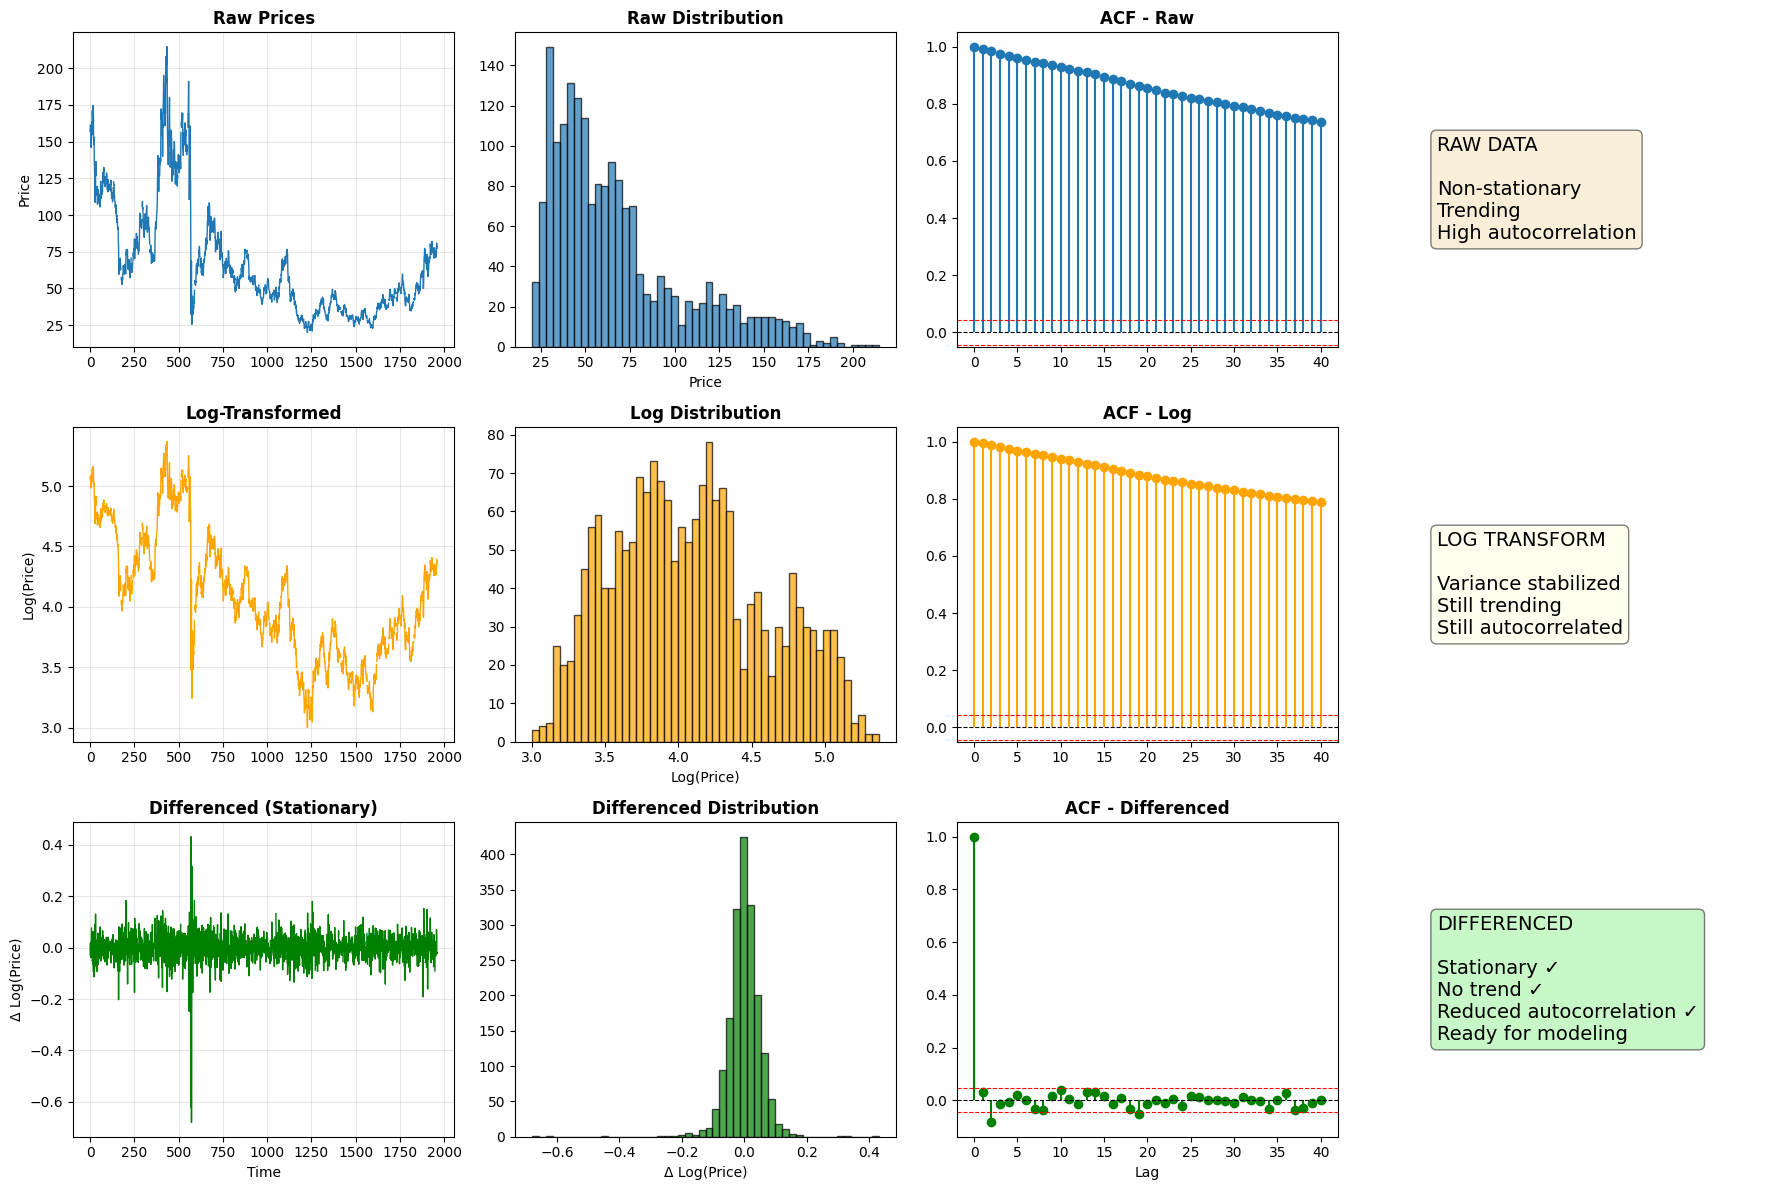

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import acf

# Create before/after comparison plots
fig, axes = plt.subplots(3, 4, figsize=(18, 12))

sample_commodity = commodity_cols[52]

# Row 1: Raw prices
axes[0, 0].plot(train[sample_commodity], linewidth=1)
axes[0, 0].set_title('Raw Prices', fontweight='bold')
axes[0, 0].set_ylabel('Price')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(train[sample_commodity].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Raw Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Price')

acf_raw = acf(train[sample_commodity].dropna(), nlags=40)
axes[0, 2].stem(range(len(acf_raw)), acf_raw, basefmt=' ')
axes[0, 2].axhline(y=0, color='k', linestyle='--', linewidth=0.8)
axes[0, 2].axhline(y=1.96/np.sqrt(len(train[sample_commodity].dropna())), color='r', linestyle='--', linewidth=0.8)
axes[0, 2].axhline(y=-1.96/np.sqrt(len(train[sample_commodity].dropna())), color='r', linestyle='--', linewidth=0.8)
axes[0, 2].set_title('ACF - Raw', fontweight='bold')

axes[0, 3].text(0.1, 0.5, 'RAW DATA\n\nNon-stationary\nTrending\nHigh autocorrelation',
                fontsize=14, verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[0, 3].axis('off')

# Row 2: Log-transformed
# Re-generate log-transformed series for plotting since transformed_df now only holds diff_log cols
temp_df_for_log_plot = apply_log_transformation(train[[sample_commodity]].copy(), [sample_commodity])
log_series_for_plot = temp_df_for_log_plot[f'{sample_commodity}_log']

axes[1, 0].plot(log_series_for_plot, linewidth=1, color='orange')
axes[1, 0].set_title('Log-Transformed', fontweight='bold')
axes[1, 0].set_ylabel('Log(Price)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(log_series_for_plot.dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_title('Log Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Log(Price)')

acf_log = acf(log_series_for_plot.dropna(), nlags=40)
axes[1, 2].stem(range(len(acf_log)), acf_log, basefmt=' ', linefmt='orange')
axes[1, 2].axhline(y=0, color='k', linestyle='--', linewidth=0.8)
axes[1, 2].axhline(y=1.96/np.sqrt(len(log_series_for_plot.dropna())), color='r', linestyle='--', linewidth=0.8)
axes[1, 2].axhline(y=-1.96/np.sqrt(len(log_series_for_plot.dropna())), color='r', linestyle='--', linewidth=0.8)
axes[1, 2].set_title('ACF - Log', fontweight='bold')

axes[1, 3].text(0.1, 0.5, 'LOG TRANSFORM\n\nVariance stabilized\nStill trending\nStill autocorrelated',
                fontsize=14, verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
axes[1, 3].axis('off')

# Row 3: Differenced (stationary)
axes[2, 0].plot(transformed_df[f'{sample_commodity}_log_diff'], linewidth=1, color='green')
axes[2, 0].set_title('Differenced (Stationary)', fontweight='bold')
axes[2, 0].set_ylabel('Δ Log(Price)')
axes[2, 0].set_xlabel('Time')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].hist(transformed_df[f'{sample_commodity}_log_diff'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2, 1].set_title('Differenced Distribution', fontweight='bold')
axes[2, 1].set_xlabel('Δ Log(Price)')

acf_diff = acf(transformed_df[f'{sample_commodity}_log_diff'].dropna(), nlags=40)
axes[2, 2].stem(range(len(acf_diff)), acf_diff, basefmt=' ', linefmt='green')
axes[2, 2].axhline(y=0, color='k', linestyle='--', linewidth=0.8)
axes[2, 2].axhline(y=1.96/np.sqrt(len(transformed_df[f'{sample_commodity}_log_diff'].dropna())), color='r', linestyle='--', linewidth=0.8)
axes[2, 2].axhline(y=-1.96/np.sqrt(len(transformed_df[f'{sample_commodity}_log_diff'].dropna())), color='r', linestyle='--', linewidth=0.8)
axes[2, 2].set_title('ACF - Differenced', fontweight='bold')
axes[2, 2].set_xlabel('Lag')

axes[2, 3].text(0.1, 0.5, 'DIFFERENCED\n\nStationary ✓\nNo trend ✓\nReduced autocorrelation ✓\nReady for modeling',
                fontsize=14, verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
axes[2, 3].axis('off')

plt.tight_layout()
plt.savefig('../results/transformation_effects.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
print("="*80)
print("RUNNING STATISTICAL TESTS ON TRANSFORMED DATA")
print("="*80)

transformed_test_results = []

# Map differenced columns back to original commodity names and exchanges
diff_col_mapping = {}
for exchange_name, commodities_df in EXCHANGES.items():
    for commodity in commodities_df.columns:
        diff_col = f'{commodity}_log_diff'
        if diff_col in transformed_df.columns:
            diff_col_mapping[diff_col] = (commodity, exchange_name)

for diff_col, (original_commodity, exchange) in diff_col_mapping.items():
    print(f"  Testing: {original_commodity} (transformed)...", end=" ")
    series = transformed_df[diff_col]
    results = comprehensive_statistical_tests(series, original_commodity, exchange)
    results['transformation_stage'] = 'log_differenced'
    transformed_test_results.append(results)

    # Print key findings
    adf_stat = "Stationary" if results.get('adf_stationary', False) else "Non-stationary"
    kpss_stat = "Stationary" if results.get('kpss_stationary', False) else "Non-stationary"
    print(f"ADF: {adf_stat}, KPSS: {kpss_stat}")

transformed_results_df = pd.DataFrame(transformed_test_results)
print(f"\n\u2713 Completed testing {len(transformed_test_results)} commodities")
print(f"\nTransformed Data Summary:")
print(f"  Stationary (ADF): {transformed_results_df['adf_stationary'].sum()} / {len(transformed_results_df)} ({transformed_results_df['adf_stationary'].mean()*100:.1f}%)")
print(f"  Stationary (KPSS): {transformed_results_df['kpss_stationary'].sum()} / {len(transformed_results_df)} ({transformed_results_df['kpss_stationary'].mean()*100:.1f}%)")
print(f"  Autocorrelated: {transformed_results_df['autocorrelated'].sum()} / {len(transformed_results_df)} ({transformed_results_df['autocorrelated'].mean()*100:.1f}%)")

RUNNING STATISTICAL TESTS ON TRANSFORMED DATA
  Testing: US_Stock_ACWI_adj_close (transformed)... ADF: Stationary, KPSS: Stationary
  Testing: US_Stock_AEM_adj_close (transformed)... ADF: Stationary, KPSS: Stationary
  Testing: US_Stock_AG_adj_close (transformed)... ADF: Stationary, KPSS: Stationary
  Testing: US_Stock_AGG_adj_close (transformed)... ADF: Stationary, KPSS: Stationary
  Testing: US_Stock_ALB_adj_close (transformed)... ADF: Stationary, KPSS: Stationary
  Testing: US_Stock_AMP_adj_close (transformed)... ADF: Stationary, KPSS: Stationary
  Testing: US_Stock_BCS_adj_close (transformed)... ADF: Stationary, KPSS: Stationary
  Testing: US_Stock_BKR_adj_close (transformed)... ADF: Stationary, KPSS: Stationary
  Testing: US_Stock_BND_adj_close (transformed)... ADF: Stationary, KPSS: Stationary
  Testing: US_Stock_BNDX_adj_close (transformed)... ADF: Stationary, KPSS: Stationary
  Testing: US_Stock_BP_adj_close (transformed)... ADF: Stationary, KPSS: Stationary
  Testing: US_Stock

BEFORE/AFTER TRANSFORMATION COMPARISON


,Metric,Raw Data (%),Transformed Data (%)
0,Stationary (ADF),2.816901,100.000000
1,Stationary (KPSS),1.408451,99.295775
2,Autocorrelated,100.000000,78.169014
3,Normal,1.408451,NaN
4,Log-Normal,1.408451,NaN


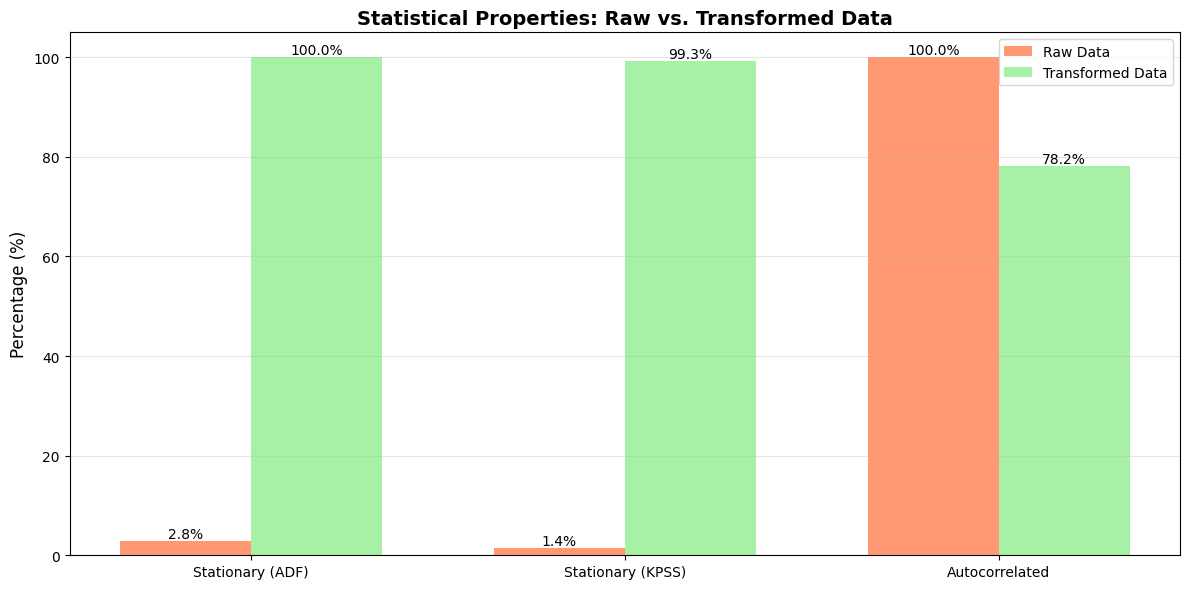

Saved: transformation_comparison.png


In [48]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Stationary (ADF)', 'Stationary (KPSS)', 'Autocorrelated', 'Normal', 'Log-Normal'],
    'Raw Data (%)': [
        raw_results_df['adf_stationary'].mean() * 100,
        raw_results_df['kpss_stationary'].mean() * 100,
        raw_results_df['autocorrelated'].mean() * 100,
        raw_results_df['is_normal'].mean() * 100,
        raw_results_df['is_log_normal'].mean() * 100
    ],
    'Transformed Data (%)': [
        transformed_results_df['adf_stationary'].mean() * 100,
        transformed_results_df['kpss_stationary'].mean() * 100,
        transformed_results_df['autocorrelated'].mean() * 100,
        np.nan,  # Not applicable for differenced data
        np.nan   # Not applicable for differenced data
    ]
})

print("="*80)
print("BEFORE/AFTER TRANSFORMATION COMPARISON")
print("="*80)
display(comparison_df)

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df['Metric'][:3]))  # Only first 3 metrics
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Raw Data (%)'][:3], width, label='Raw Data', color='coral', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Transformed Data (%)'][:3], width, label='Transformed Data', color='lightgreen', alpha=0.8)

ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Statistical Properties: Raw vs. Transformed Data', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'][:3])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../results/transformation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: transformation_comparison.png")

In [50]:
print("="*80)
print("EXPORTING RESULTS TO CSV")
print("="*80)

# Export raw test results
raw_results_df['transformation_stage'] = 'raw'
raw_results_df.to_csv('../results/statistical_tests_raw.csv', index=False)
print(f"✓ Exported: statistical_tests_raw.csv ({len(raw_results_df)} rows)")

# Export transformed test results
transformed_results_df.to_csv('../results/statistical_tests_transformed.csv', index=False)
print(f"✓ Exported: statistical_tests_transformed.csv ({len(transformed_results_df)} rows)")

# Export combined results
combined_results = pd.concat([raw_results_df, transformed_results_df], ignore_index=True)
combined_results.to_csv('../results/statistical_tests_complete.csv', index=False)
print(f"✓ Exported: statistical_tests_complete.csv ({len(combined_results)} rows)")

# Export comparison summary
comparison_df.to_csv('../results/transformation_comparison_summary.csv', index=False)
print(f"✓ Exported: transformation_comparison_summary.csv")

# Create detailed summary by exchange
exchange_summary = combined_results.groupby(['exchange', 'transformation_stage']).agg({
    'adf_stationary': 'mean',
    'kpss_stationary': 'mean',
    'autocorrelated': 'mean',
    'is_normal': 'mean',
    'is_log_normal': 'mean',
    'skewness': 'mean',
    'kurtosis': 'mean',
    'has_linear_trend': 'mean'
}).reset_index()

exchange_summary.columns = ['Exchange', 'Stage', 'ADF_Stationary_%', 'KPSS_Stationary_%',
                            'Autocorrelated_%', 'Normal_%', 'LogNormal_%',
                            'Avg_Skewness', 'Avg_Kurtosis', 'Linear_Trend_%']

# Convert percentages
for col in ['ADF_Stationary_%', 'KPSS_Stationary_%', 'Autocorrelated_%', 'Normal_%', 'LogNormal_%', 'Linear_Trend_%']:
    exchange_summary[col] = exchange_summary[col] * 100

exchange_summary.to_csv('../results/exchange_wise_summary.csv', index=False)
print(f"✓ Exported: exchange_wise_summary.csv")

print("\nExchange-wise Summary:")
display(exchange_summary)

EXPORTING RESULTS TO CSV
✓ Exported: statistical_tests_raw.csv (142 rows)
✓ Exported: statistical_tests_transformed.csv (142 rows)
✓ Exported: statistical_tests_complete.csv (284 rows)
✓ Exported: transformation_comparison_summary.csv
✓ Exported: exchange_wise_summary.csv

Exchange-wise Summary:


,Exchange,Stage,ADF_Stationary_%,KPSS_Stationary_%,Autocorrelated_%,Normal_%,LogNormal_%,Avg_Skewness,Avg_Kurtosis,Linear_Trend_%
0,FX,log_differenced,100.000000,100.00000,76.315789,0.000000,0.00000,-0.169457,9.483748,0.0
1,FX,raw,5.263158,0.00000,100.000000,5.263158,0.00000,0.114841,-0.562519,100.0
2,JPX,log_differenced,100.000000,100.00000,83.333333,0.000000,0.00000,-0.561436,7.111999,0.0
3,JPX,raw,0.000000,0.00000,100.000000,0.000000,0.00000,0.814169,0.060605,100.0
4,LME,log_differenced,100.000000,100.00000,0.000000,0.000000,0.00000,-0.055675,1.862733,0.0
5,LME,raw,25.000000,25.00000,100.000000,0.000000,25.00000,0.309344,0.096860,100.0
6,US,log_differenced,100.000000,98.93617,81.914894,0.000000,0.00000,-0.739384,18.764692,0.0
7,US,raw,1.063830,1.06383,100.000000,0.000000,1.06383,0.328117,-0.506858,100.0


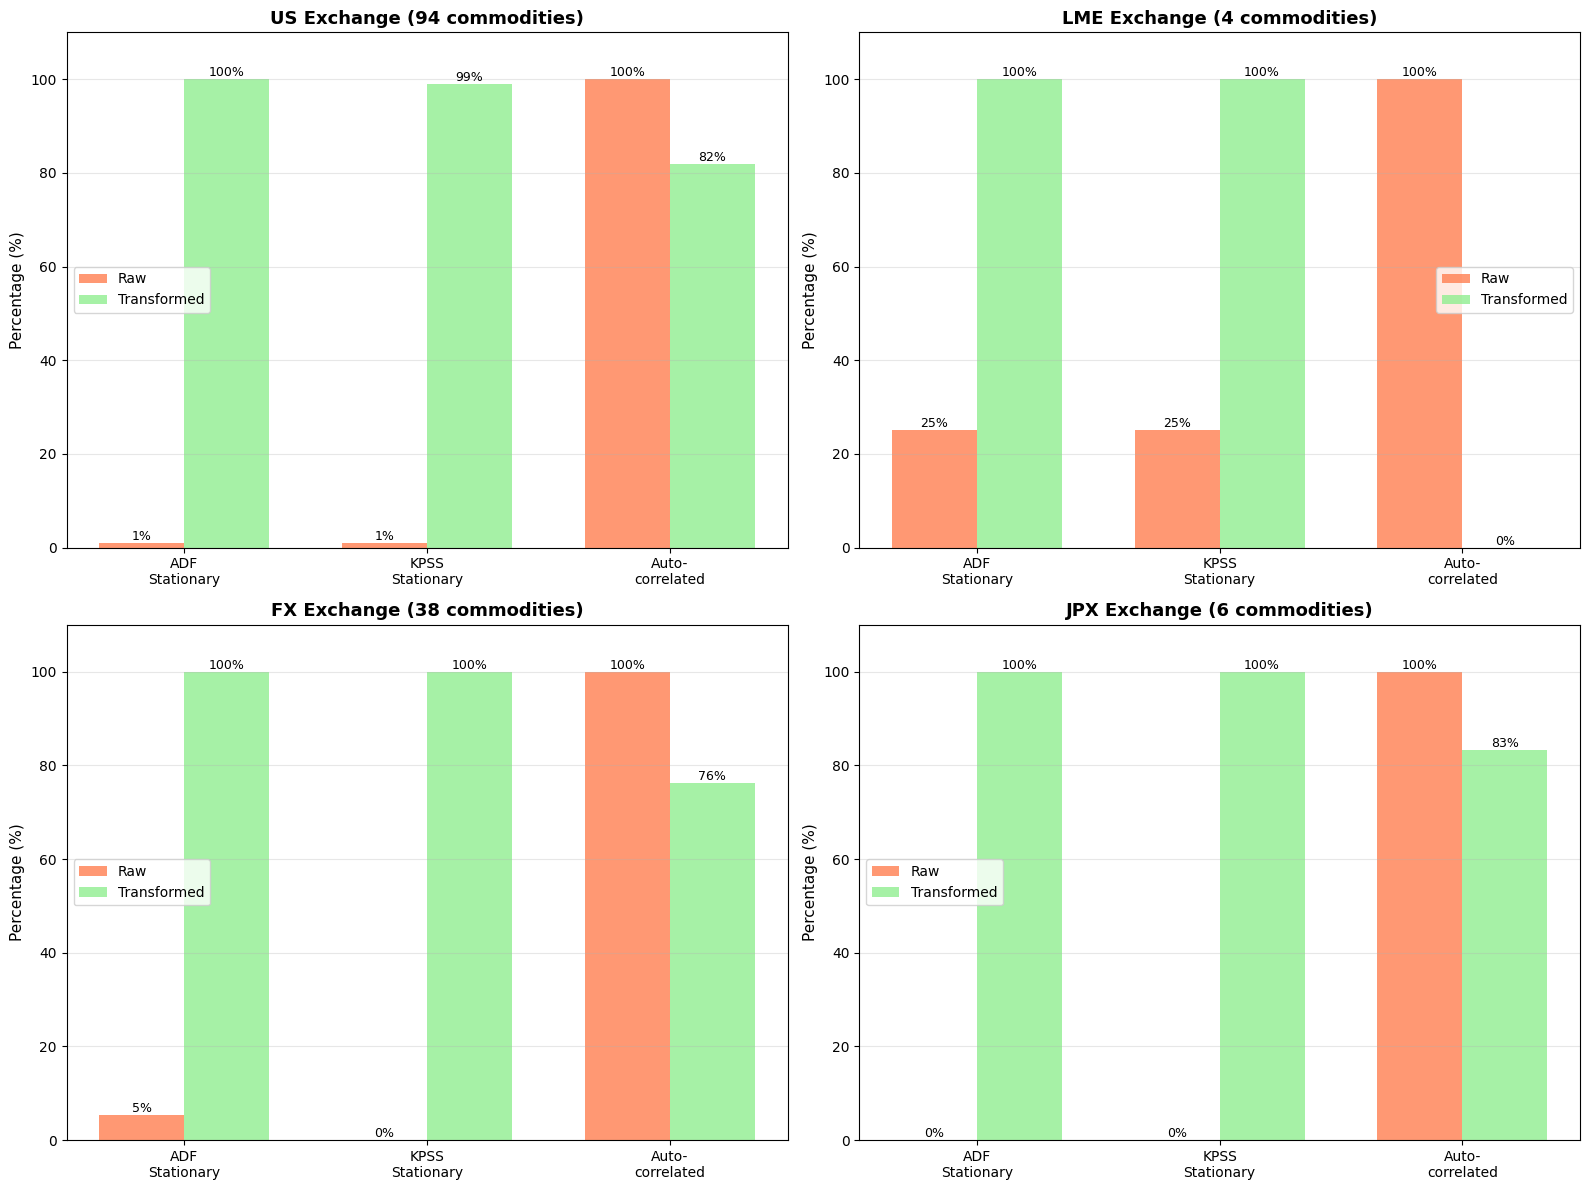

Saved: exchange_wise_comparison.png


In [53]:
# Create grouped bar chart for each exchange
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, exchange in enumerate(['US', 'LME', 'FX', 'JPX']):
    ax = axes[idx]
    
    # Filter data for this exchange
    exchange_raw = raw_results_df[raw_results_df['exchange'] == exchange]
    exchange_trans = transformed_results_df[transformed_results_df['exchange'] == exchange]
    
    if len(exchange_raw) == 0:
        ax.text(0.5, 0.5, f'No data for {exchange}', ha='center', va='center', fontsize=14)
        ax.axis('off')
        continue
    
    metrics = ['ADF\nStationary', 'KPSS\nStationary', 'Auto-\ncorrelated']
    raw_values = [
        exchange_raw['adf_stationary'].mean() * 100,
        exchange_raw['kpss_stationary'].mean() * 100,
        exchange_raw['autocorrelated'].mean() * 100
    ]
    trans_values = [
        exchange_trans['adf_stationary'].mean() * 100,
        exchange_trans['kpss_stationary'].mean() * 100,
        exchange_trans['autocorrelated'].mean() * 100
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, raw_values, width, label='Raw', color='coral', alpha=0.8)
    bars2 = ax.bar(x + width/2, trans_values, width, label='Transformed', color='lightgreen', alpha=0.8)
    
    ax.set_ylabel('Percentage (%)', fontsize=11)
    ax.set_title(f'{exchange} Exchange ({len(exchange_raw)} commodities)', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 110])
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../results/exchange_wise_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: exchange_wise_comparison.png")